In [14]:
import numpy as np
import pandas as pd
import seaborn as sns

import pickle
import xgboost

import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.feature_selection import SelectKBest, chi2, mutual_info_classif

Reading our data

In [15]:
df = pd.read_csv('heart.csv')
df.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1


In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       303 non-null    int64  
 1   sex       303 non-null    int64  
 2   cp        303 non-null    int64  
 3   trestbps  303 non-null    int64  
 4   chol      303 non-null    int64  
 5   fbs       303 non-null    int64  
 6   restecg   303 non-null    int64  
 7   thalach   303 non-null    int64  
 8   exang     303 non-null    int64  
 9   oldpeak   303 non-null    float64
 10  slope     303 non-null    int64  
 11  ca        303 non-null    int64  
 12  thal      303 non-null    int64  
 13  target    303 non-null    int64  
dtypes: float64(1), int64(13)
memory usage: 33.3 KB


Dropping dome rows


Thal column is very unbalanced that's why we are dropping thal = 0 instance 
which are jus 2

In [17]:
df['thal'].value_counts()

2    166
3    117
1     18
0      2
Name: thal, dtype: int64

Creating features and target dataframes

In [18]:
X = df.drop('target',axis=1)
y = df['target']

X.shape, y.shape

((303, 13), (303,))

Using correlation matrix

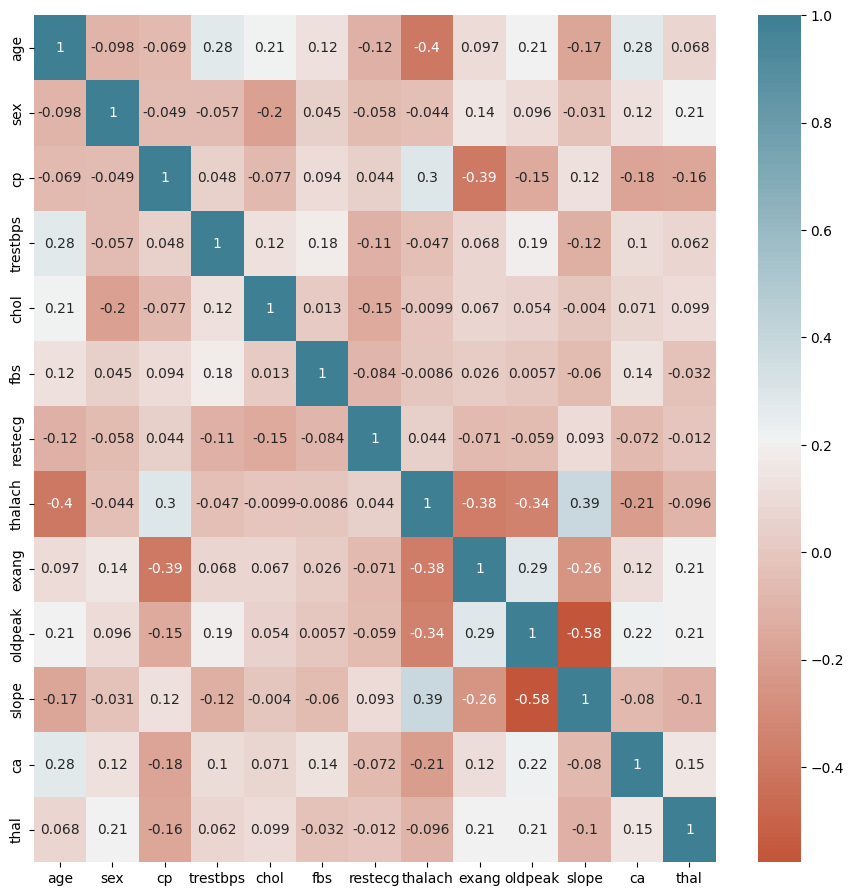

In [19]:
corr_mat = X.corr()
plt.figure(figsize=(11, 11))
g = sns.heatmap(corr_mat, annot=True, cmap=sns.diverging_palette(20, 220, n=200))

Select k best using chi^2 test

Using feature importance - This technique gives you a score for each feature of your data, the higher the score more relevant it is

In [20]:
ordered_rank_features = SelectKBest(score_func=chi2, k=13)
ordered_feature = ordered_rank_features.fit(X, y)

feat_imp = pd.DataFrame(ordered_feature.scores_,index=X.columns, columns=["Score"])
feat_imp.sort_values(by='Score',inplace=True,ascending=False)
feat_imp

,Score
thalach,188.320472
oldpeak,72.644253
ca,66.440765
cp,62.598098
exang,38.914377
chol,23.936394
age,23.286624
trestbps,14.823925
slope,9.804095
sex,7.576835


Using information gain

In [21]:
mutual_info = mutual_info_classif(X, y)
mutual_info_df = pd.DataFrame(mutual_info*100, index=X.columns,columns=['Score'])
mutual_info_df.sort_values(by='Score',inplace=True,ascending=False)
mutual_info_df

,Score
thal,15.270931
ca,13.920035
oldpeak,12.605462
slope,10.261555
cp,9.547354
exang,9.288974
chol,6.486056
thalach,5.247077
sex,3.146735
restecg,1.540739


Final Selection

In [22]:
final_selected_features = ['ca', 'cp', 'exang', 'thal', 'oldpeak', 'thalach','age']
X = X[final_selected_features]
X.shape

(303, 7)

In [23]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=42)

Training Random Forest

In [24]:
rfc = RandomForestClassifier()
rfc.fit(X_train, y_train)

# random forest classifier accuracy:
y_preds = rfc.predict(X_test)
print("Accuracy : {:.2f}%".format(accuracy_score(y_test, y_preds)*100))

Accuracy : 78.26%


Training XGBoost

In [12]:
clf = xgboost.XGBClassifier()
clf.fit(X_train, y_train)

# xgboost classifier accuracy:
y_preds = clf.predict(X_test)
print("Accuracy : {:.2f}%".format(accuracy_score(y_test, y_preds)*100))

Accuracy : 78.26%


In [13]:
# saving trained model
filename = '../models/heart_disease.pickle.dat'
pickle.dump(rfc, open(filename, 'wb'))